In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

### Preprocessing

In [4]:
# Load your long-format dataset
df = pd.read_csv("final_flat_dataset.csv")  # use your actual path

# Clean and group by patient
df = df[df['drug'].notna() & df['diagnosis'].notna()]
df['drug'] = df['drug'].astype(str).str.strip()
df['diagnosis'] = df['diagnosis'].astype(str).str.strip()

grouped = df.groupby('subject_id').agg({
    'drug': lambda x: list(set(x)),
    'diagnosis': 'first'
}).reset_index()

# Input: multi-hot encode drugs
mlb = MultiLabelBinarizer()
X = mlb.fit_transform(grouped['drug'])

# Output: encode diagnosis
le = LabelEncoder()
y_encoded = le.fit_transform(grouped['diagnosis'])
y = np.eye(len(le.classes_))[y_encoded]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model

In [5]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    m = y_true.shape[0]
    log_likelihood = -np.log(y_pred[range(m), y_true.argmax(axis=1)] + 1e-9)
    return np.mean(log_likelihood)

def init_mlp(input_dim, hidden_dim, output_dim):
    return {
        "W1": np.random.randn(input_dim, hidden_dim) * 0.01,
        "b1": np.zeros((1, hidden_dim)),
        "W2": np.random.randn(hidden_dim, output_dim) * 0.01,
        "b2": np.zeros((1, output_dim)),
    }

def forward_pass(X, params):
    Z1 = np.dot(X, params["W1"]) + params["b1"]
    A1 = relu(Z1)
    Z2 = np.dot(A1, params["W2"]) + params["b2"]
    A2 = softmax(Z2)
    return A2, {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}

def backward_pass(X, y_true, params, cache):
    m = X.shape[0]
    dZ2 = cache["A2"] - y_true
    dW2 = np.dot(cache["A1"].T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    dA1 = np.dot(dZ2, params["W2"].T)
    dZ1 = dA1 * relu_derivative(cache["Z1"])
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    return {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}

def update_params(params, grads, lr):
    for key in params:
        params[key] -= lr * grads["d" + key]
    return params

def train_step(X, y_true, params, lr=0.1):
    y_pred, cache = forward_pass(X, params)
    loss = cross_entropy_loss(y_pred, y_true)
    grads = backward_pass(X, y_true, params, cache)
    params = update_params(params, grads, lr)
    return loss, params

### Training

In [6]:
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = y_train.shape[1]
params = init_mlp(input_dim, hidden_dim, output_dim)

losses = []
accuracy = []
for epoch in range(100):
    loss, params = train_step(X_train, y_train, params, lr=0.1)
    losses.append(loss)

    # Optional accuracy
    y_pred_probs, _ = forward_pass(X_train, params)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_train, axis=1)
    acc = np.mean(y_pred == y_true)
    accuracy.append(acc)

    print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

Epoch 1, Loss: 4.2194, Accuracy: 0.0533
Epoch 2, Loss: 4.2183, Accuracy: 0.0667
Epoch 3, Loss: 4.2172, Accuracy: 0.0800
Epoch 4, Loss: 4.2161, Accuracy: 0.0800
Epoch 5, Loss: 4.2150, Accuracy: 0.0800
Epoch 6, Loss: 4.2140, Accuracy: 0.0667
Epoch 7, Loss: 4.2129, Accuracy: 0.0667
Epoch 8, Loss: 4.2118, Accuracy: 0.0667
Epoch 9, Loss: 4.2107, Accuracy: 0.0667
Epoch 10, Loss: 4.2097, Accuracy: 0.0667
Epoch 11, Loss: 4.2086, Accuracy: 0.0667
Epoch 12, Loss: 4.2075, Accuracy: 0.0667
Epoch 13, Loss: 4.2064, Accuracy: 0.0667
Epoch 14, Loss: 4.2053, Accuracy: 0.0667
Epoch 15, Loss: 4.2042, Accuracy: 0.0667
Epoch 16, Loss: 4.2031, Accuracy: 0.0667
Epoch 17, Loss: 4.2020, Accuracy: 0.0667
Epoch 18, Loss: 4.2009, Accuracy: 0.0667
Epoch 19, Loss: 4.1998, Accuracy: 0.0667
Epoch 20, Loss: 4.1987, Accuracy: 0.0667
Epoch 21, Loss: 4.1976, Accuracy: 0.0667
Epoch 22, Loss: 4.1964, Accuracy: 0.0667
Epoch 23, Loss: 4.1953, Accuracy: 0.0667
Epoch 24, Loss: 4.1941, Accuracy: 0.0667
Epoch 25, Loss: 4.1929, A

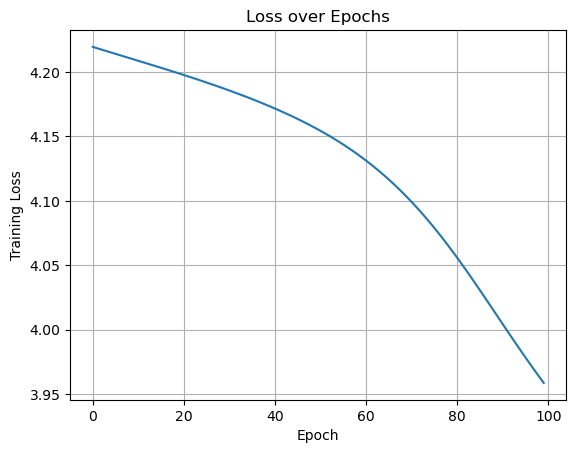

In [7]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss over Epochs")
plt.grid(True)
plt.show()

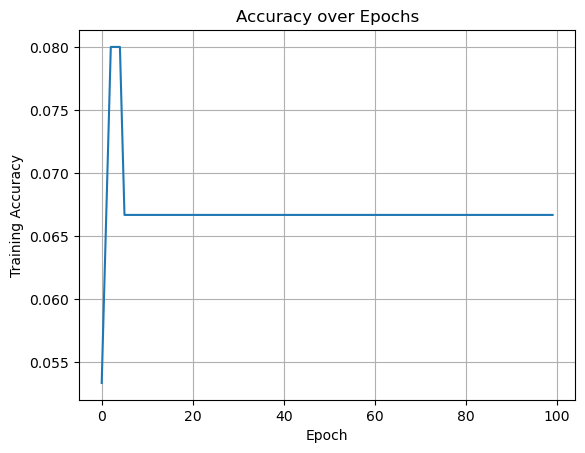

In [8]:
plt.plot(accuracy)
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("Accuracy over Epochs")
plt.grid(True)
plt.show()

### Eval

In [9]:
# Test set prediction
y_pred_probs, _ = forward_pass(X_test, params)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics
print("Test Accuracy:", accuracy_score(y_true, y_pred))

# Get only the classes present in y_true or y_pred
labels_in_test = np.unique(np.concatenate([y_true, y_pred]))
print(classification_report(
    y_true,
    y_pred,
    labels=labels_in_test,
    target_names=le.inverse_transform(labels_in_test)
))

Test Accuracy: 0.10526315789473684
                                                                             precision    recall  f1-score   support

                                      Acute and chronic respiratory failure       0.00      0.00      0.00         1
                                       Acute and subacute necrosis of liver       0.00      0.00      0.00         1
                                                        Acute cholecystitis       0.00      0.00      0.00         1
Acute myocardial infarction of other inferior wall, initial episode of care       0.00      0.00      0.00         1
                                               Acute systolic heart failure       0.00      0.00      0.00         1
                                Angiodysplasia of intestine with hemorrhage       0.00      0.00      0.00         1
                              Cirrhosis of liver without mention of alcohol       0.00      0.00      0.00         1
                            

c:\Users\willi\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\willi\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\willi\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

C:\Users\willi\AppData\Local\Temp\ipykernel_5400\543766384.py:10: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


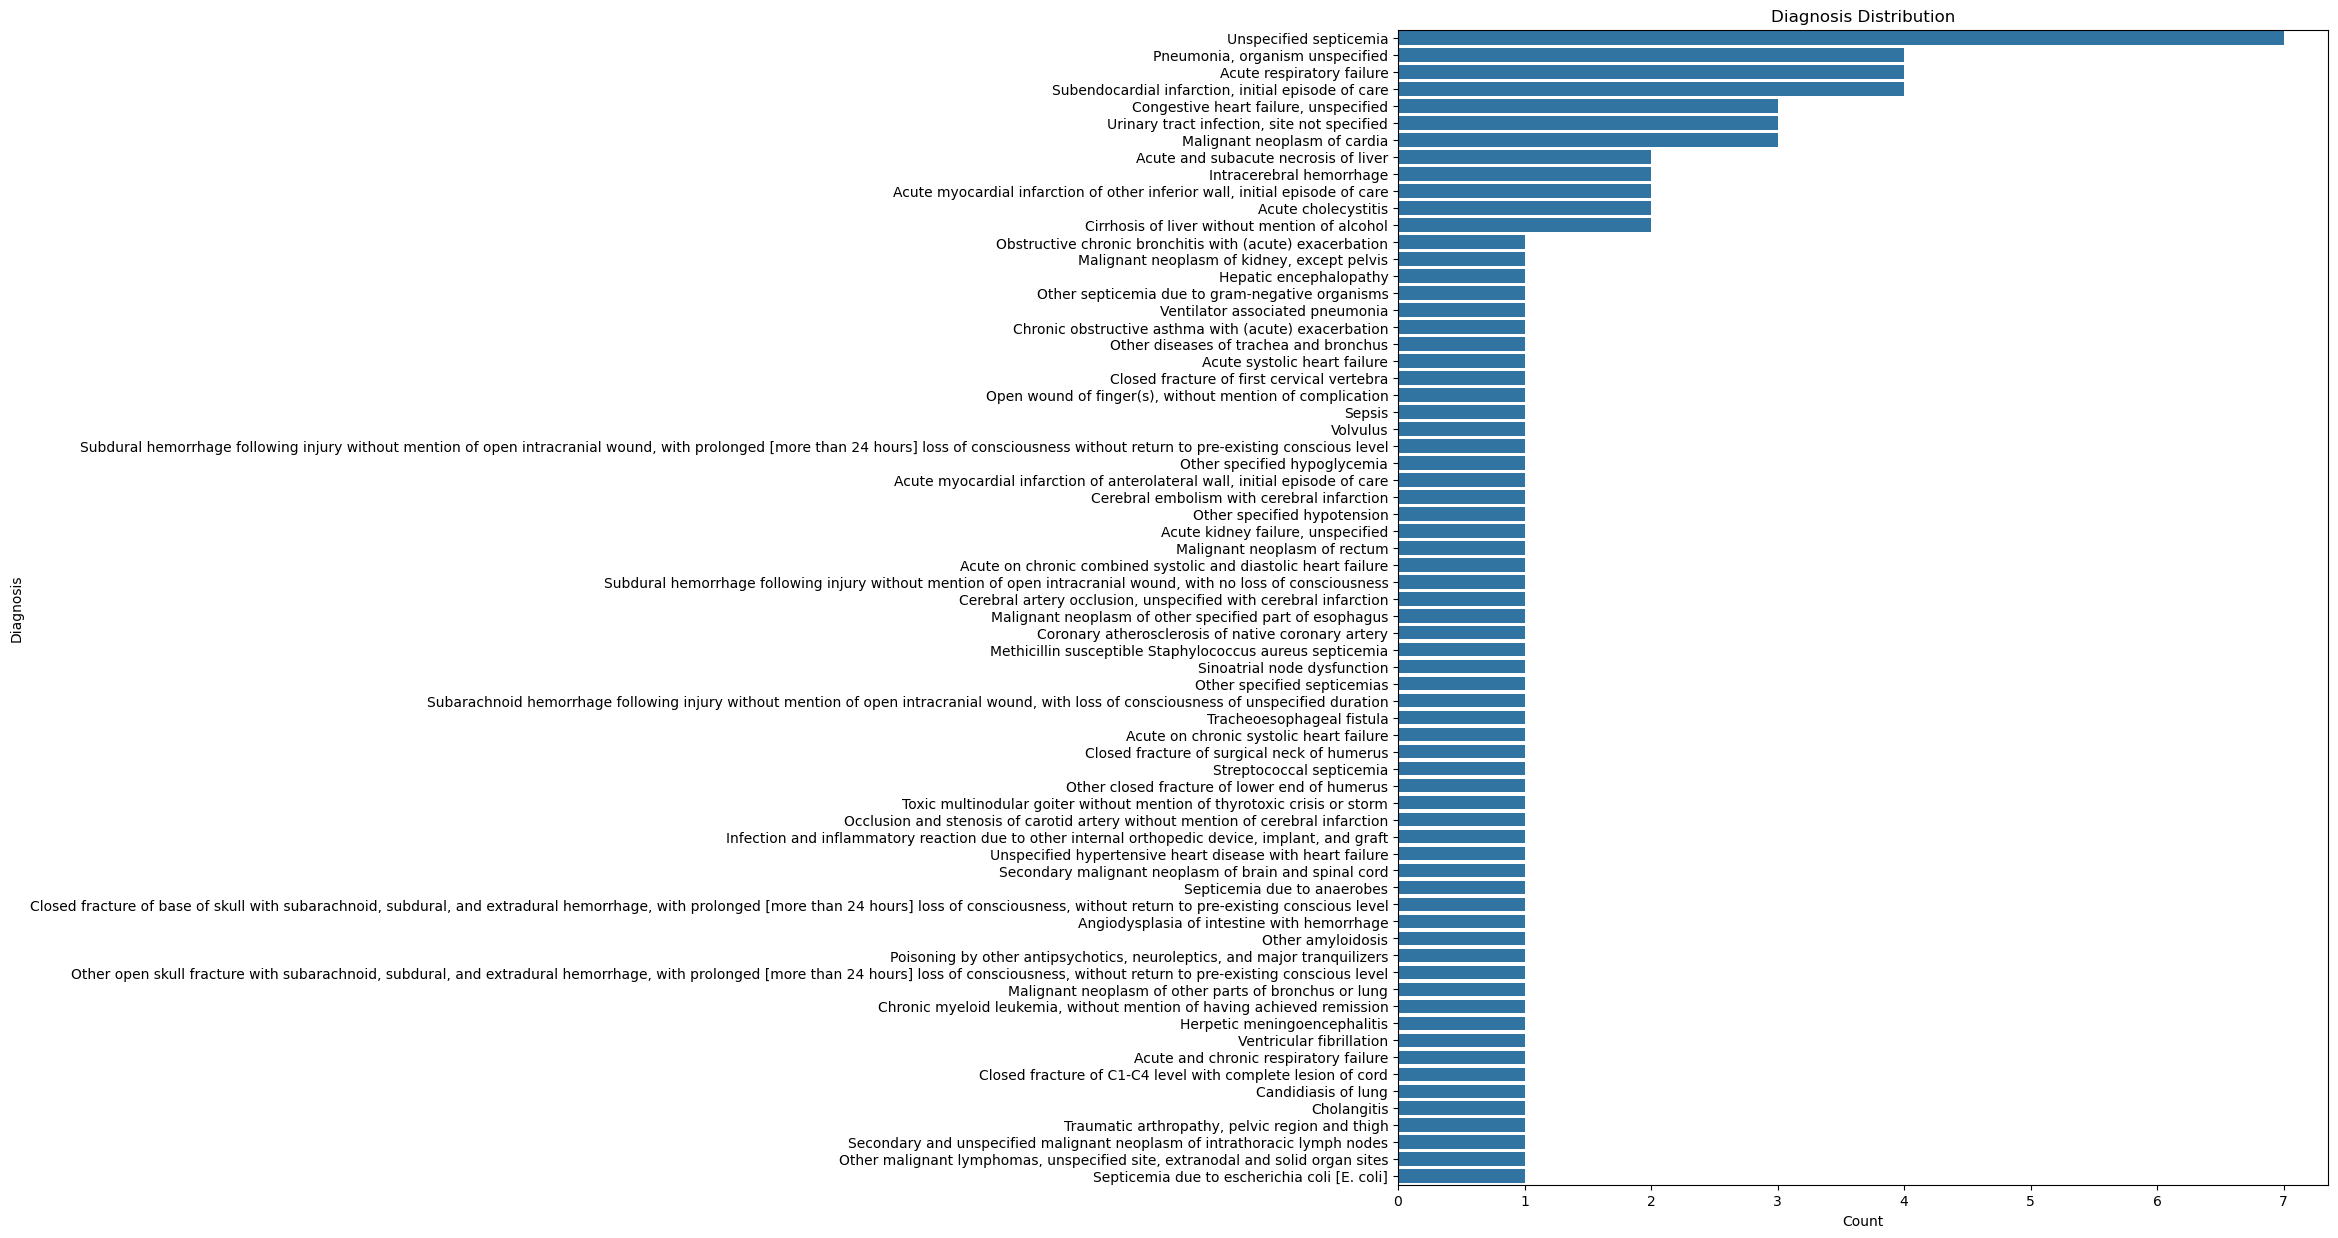

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 15))  # or taller!

sns.countplot(y=grouped['diagnosis'], order=grouped['diagnosis'].value_counts().index)
plt.title("Diagnosis Distribution")
plt.xlabel("Count")
plt.ylabel("Diagnosis")
plt.tight_layout()
plt.show()

In [12]:
# saving the output 
import pickle

# Save model parameters and encoders
with open("mlp_model.pkl", "wb") as f:
    pickle.dump(params, f)

with open("diagnosis_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

with open("drug_encoder.pkl", "wb") as f:
    pickle.dump(mlb, f)